In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, glob
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa
import math

In [3]:
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

### Data generator

In [4]:
IMAGE_SIZE = 32
BATCH_SIZE = 32
SEED = 7
INPUT_SHAPE = (IMAGE_SIZE,IMAGE_SIZE,3)

In [5]:
val_path = '../../datasets/input/cropedandrotated/images'
train_path = '../../datasets/input/cropedandrotated/images'
test_path = '../../datasets/input/cropedandrotated/images/'
df_train_path = '../../datasets/input/cropedandrotated/csv/train.csv'
df_classes_path = '../../datasets/input/cropedandrotated/csv/class.csv'
df_test_path = '../../datasets/input/cropedandrotated/csv/test.csv'

In [6]:
df_train = pd.read_csv(df_train_path, dtype='str')
df_classes = pd.read_csv(df_classes_path)
df_test = pd.read_csv(df_test_path, dtype='str')

In [7]:
train_gen = datagen.flow_from_dataframe(dataframe=df_train,
                                        directory=train_path,
                                        x_col = 'filename',
                                        y_col = 'label',
                                        batch_size=BATCH_SIZE,
                                        class_mode='sparse',
                                        # shuffle=True,
                                        seed=SEED,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE)
)

Found 23249 validated image filenames belonging to 33 classes.


In [8]:
val_gen = datagen.flow_from_dataframe(dataframe=df_train,
                                        directory=val_path,
                                        x_col = 'filename',
                                        y_col = 'label',
                                        batch_size=BATCH_SIZE,
                                        class_mode='sparse',
                                        # shuffle=True,
                                        seed=SEED,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE)
)

Found 23249 validated image filenames belonging to 33 classes.


In [9]:
test_gen = datagen.flow_from_dataframe(dataframe=df_test,
                                        directory=test_path,
                                        x_col = 'filename',
                                        y_col = 'label',
                                        batch_size=BATCH_SIZE,
                                        class_mode='sparse',
                                        # shuffle=True,
                                        seed=SEED,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE)
)

Found 5791 validated image filenames belonging to 33 classes.


In [10]:
x_train, y_train = next(train_gen)
x_valid, y_valid = next(val_gen)
x_test, y_test = next(test_gen)

In [11]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape} - y_valid shape: {y_valid.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (32, 32, 32, 3) - y_train shape: (32,)
x_valid shape: (32, 32, 32, 3) - y_valid shape: (32,)
x_test shape: (32, 32, 32, 3) - y_test shape: (32,)


# Hyper-parameter

In [12]:
"""DATA"""
NUM_CLASSES = 33
INPUT_SHAPE = (IMAGE_SIZE,IMAGE_SIZE,3)
BUFFER_SIZE = 256

"""AUGMENTATION"""
PATCH_SIZE = 8
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

"""OPTIMIZER"""
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

"""TRAINING"""
# EPOCHS = 64
EPOCHS = 64

"""ARCHITECTURE"""
LAYER_NORM_EPS = 1e-6
#TRANSFORMER_LAYERS = 8
TRANSFORMER_LAYERS = 4
# PROJECTION_DIM = 64
PROJECTION_DIM = 64
#NUM_HEADS = 4
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
#MLP_HEAD_UNITS = [128, 128]
MLP_HEAD_UNITS = [2048, 1024]
# MLP_HEAD_UNITS = [4, 32]

In [13]:
from tensorflow import keras
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
"""Compute the mean and the variance of the training data for normalization."""
data_augmentation.layers[0].adapt(x_train)

In [14]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

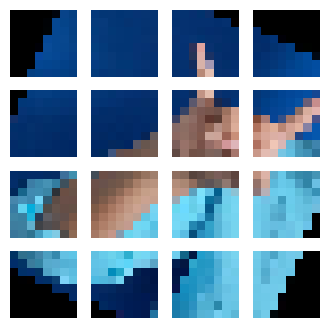

ORIGINAL


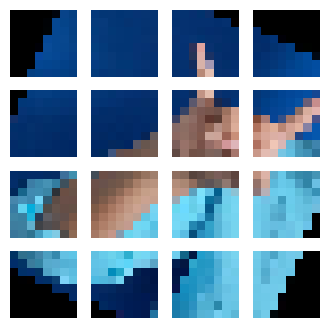

LEFT-UP


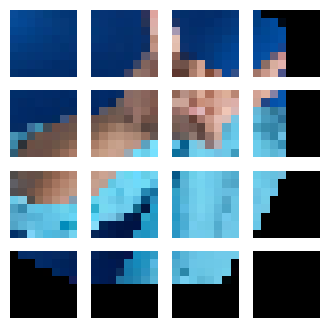

LEFT-DOWN


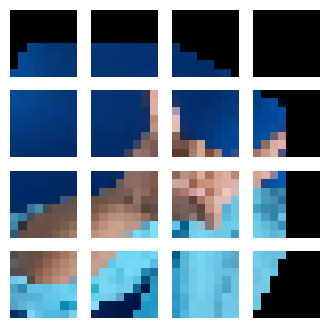

RIGHT-UP


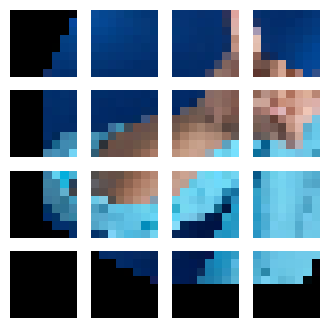

RIGHT-DOWN


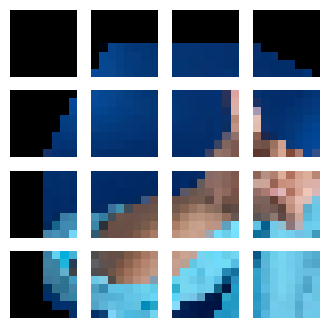

In [15]:
"""Get a random image from the training dataset and resize the image"""
image = x_train[np.random.choice(range(x_train.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

"""Vanilla patch maker: This takes an image and divides into patches as in the original ViT paper"""
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
#(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 32.0)


(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

"""Shifted Patch Tokenization: This layer takes the image, shifts it diagonally and then extracts patches from the concatinated images"""
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)

(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

In [16]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [17]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

In [18]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


"""Build the diagonal attention mask"""
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

In [19]:
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    print(model.summary())
    return model

In [20]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

In [21]:
"""Some code is taken from: https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2."""
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_experiment(model):
    total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    # Got error with this optimizer
    # optimizer = tfa.optimizers.AdamW(
    #    learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    # )
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)


    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    # model.compile(
    #     optimizer=optimizer,
    #     loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    #     metrics=[
    #         keras.metrics.CategoricalAccuracy(name="accuracy"),
    #         keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    #     ],
    # )


    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
        
    )

    return history


In [22]:
def plotting(history):
    ### Plot train and validation curves
    loss = history.history['loss']
    v_loss = history.history['val_loss']
    # loss = vit.history['loss']
    # v_loss = vit.history['val_loss']

    acc = history.history['accuracy']
    v_acc = history.history['val_accuracy']

    # acc = vit.history['accuracy'] 
    # v_acc = vit.history['val_accuracy']

    top5_acc = history.history['top-5-accuracy']
    val_top5_acc = history.history['val_top-5-accuracy']
    epochs = range(len(loss))

    fig = plt.figure(figsize=(20, 4))
    plt.subplot(1, 3, 1)
    plt.yscale('log')
    plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
    plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
    # plt.ylim(0.3, 100)
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
    plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=12)
    plt.subplot(1, 3, 3)
    plt.plot(epochs, top5_acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
    plt.plot(epochs, val_top5_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


### Train with vanilla true

In [23]:
vit = create_vit_classifier(vanilla=True)
history = run_experiment(vit)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 32, 32, 3)   7           ['input_1[0][0]']                
                                                                                                  
 shifted_patch_tokenization_2 (  ((None, 16, 64),    12352       ['data_augmentation[0][0]']      
 ShiftedPatchTokenization)       (None, 4, 4, 192))                                               
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 16, 64)       1024        ['shifted_patch_tokenization_

1/1 [==============================] - 0s 45ms/step - loss: 9.5794 - accuracy: 0.0938 - top-5-accuracy: 0.2812
Test accuracy: 9.38%
Test top 5 accuracy: 28.12%


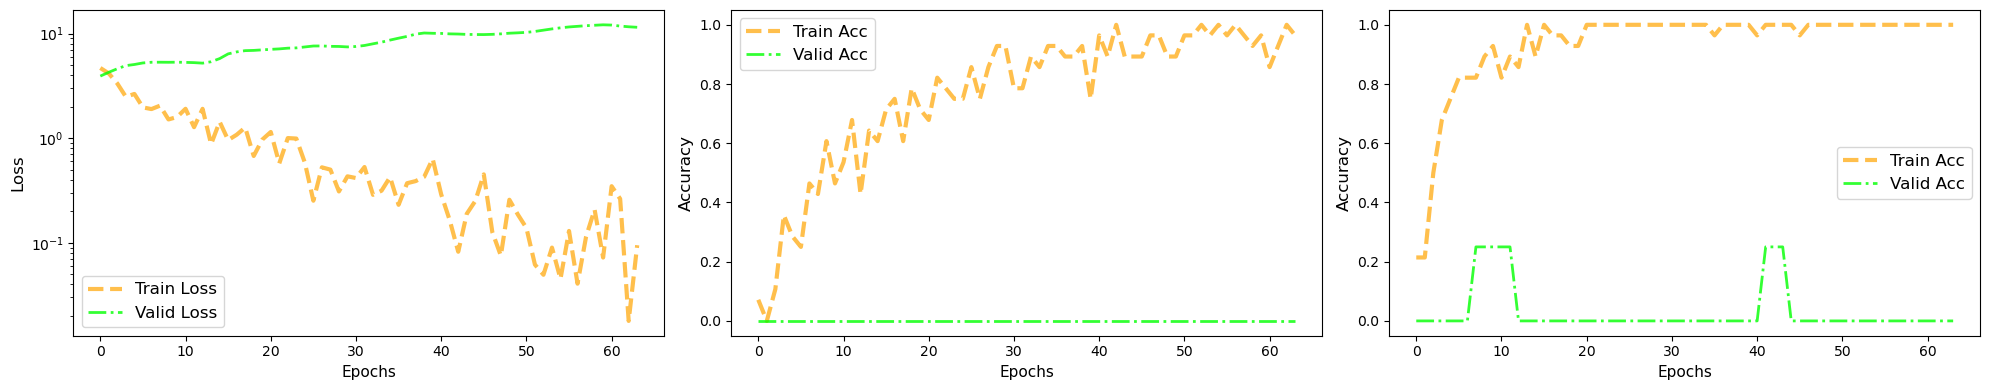

In [24]:
"""Evaluate with testing data"""
_, accuracy, top_5_accuracy = history.model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
plotting(history)

### Train with false vanilla

In [25]:
vit_false = create_vit_classifier(vanilla=False)
history_false = run_experiment(vit_false)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 32, 32, 3)   7           ['input_2[0][0]']                
                                                                                                  
 shifted_patch_tokenization_3 (  ((None, 16, 64),    63424       ['data_augmentation[1][0]']      
 ShiftedPatchTokenization)       (None, 4, 4, 960))                                               
                                                                                                  
 patch_encoder_1 (PatchEncoder)  (None, 16, 64)      1024        ['shifted_patch_tokenizatio

1/1 [==============================] - 0s 39ms/step - loss: 9.1233 - accuracy: 0.1250 - top-5-accuracy: 0.2812
Test accuracy: 12.5%
Test top 5 accuracy: 28.12%


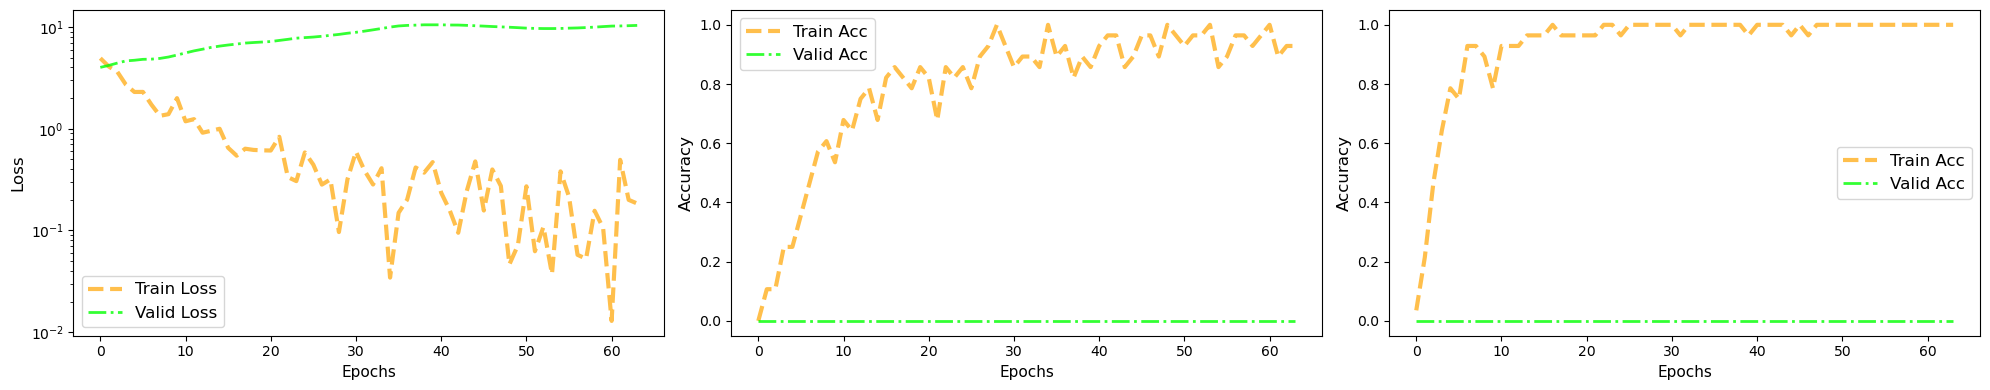

In [26]:
"""Evaluate with testing data"""
_, false_accuracy, false_top_5_accuracy = history_false.model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print(f"Test accuracy: {round(false_accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(false_top_5_accuracy * 100, 2)}%")
plotting(history_false)

# Prediction

In [27]:
import cv2
import numpy as np

In [28]:
classes = list(df_classes['class_name'])
label = [[index,data] for index,data in enumerate(classes)]
dict_classes = {}
for i,j in label:
    dict_classes[i] = j

In [66]:
def cvttoprop(prediction):
    expo = np.exp(prediction)
    prop = expo / np.sum(expo)
    # print(prop)
    return list(prop)

def prediction(model, image_path):
    img = cv2.imread(image_path)
    print("--------------------------")
    print("Original image shape: ",img.shape)

    #resize the image
    img = cv2.resize(img,dsize=(IMAGE_SIZE,IMAGE_SIZE))
    img = img.reshape(1,IMAGE_SIZE,IMAGE_SIZE,3)

    #make prediction
    prediction = model.predict(img, batch_size=BATCH_SIZE)
    print("--------------------------")
    print("Prediction logits: ", prediction)
    print("Length of prediction logits: ", len(prediction[0]))

    #convert to probability
    pro = cvttoprop(prediction[0])
    top1 = pro.index(max(pro))
    print("--------------------------")
    print("top1: ",top1)
    print("--------------------------")

    #sorting
    out = [i for i in pro]
    out.sort()
    out.reverse()

    #make output
    output = {}
    for i in out:
        output[dict_classes[pro.index(i)]] = i*100

    return output

In [243]:
image_path = r'../../datasets/input/cropedandrotated/images/1-tho1_-25.jpg'
result = prediction(history.model,image_path)
result

--------------------------
Original image shape:  (800, 800, 3)
1/1 [==============================] - 0s 16ms/step
--------------------------
Prediction logits:  [[ -6.362682    -5.1947303   -7.6620455   -6.5445175   -9.516046
    3.0485947    1.0243776   -3.112776     4.342966    -3.7716482
    1.3584211   -8.84525     -4.778913     5.56205    -10.082648
    0.5097507   -4.822525    -6.817306     3.9481032   -0.8896105
   -6.424655    -8.640121    -8.129854     9.948105     7.220107
   -9.0047455   -0.19457951  -6.2913904    4.957115    -7.7912474
   -6.523469    -6.033855    -3.4398904 ]]
Length of prediction logits:  33
--------------------------
top1:  23
--------------------------


{'ro': 91.55590534210205,
 'sa': 5.983178690075874,
 'lo': 1.1398478411138058,
 'tho1': 0.6224824115633965,
 'ka': 0.3368259407579899,
 'no': 0.22694403305649757,
 'da': 0.0923139217775315,
 'kho': 0.01703076413832605,
 'do': 0.01219441182911396,
 'na': 0.00728888699086383,
 'tha1': 0.0036039149563293904,
 'or': 0.0017985657905228436,
 'ha': 0.00019472327039693482,
 'yo': 0.0001403957298862224,
 'kha': 0.00010075655154651031,
 'la': 3.679796236610855e-05,
 'ngo': 3.522761744534364e-05,
 'cha': 2.427932486170903e-05,
 'vo': 1.04908181697283e-05,
 'tha2': 8.108922600058577e-06,
 'ba': 7.550951153234564e-06,
 'pha': 7.097200693806371e-06,
 'to': 6.429433341281765e-06,
 'chho': 6.295517351873059e-06,
 'nho': 4.792486762994486e-06,
 'chha': 2.0591844673845117e-06,
 'tho2': 1.8096040221848853e-06,
 'po': 1.289818207794724e-06,
 'pho': 7.743231833501341e-07,
 'ko': 6.30719121375023e-07,
 'ta': 5.377347012114342e-07,
 'cho': 3.224877698215778e-07,
 'mo': 1.8299568527169185e-07}

In [244]:
result_false = prediction(history_false.model,image_path)
result_false

--------------------------
Original image shape:  (800, 800, 3)
1/1 [==============================] - 0s 16ms/step
--------------------------
Prediction logits:  [[-6.1240458e+00 -5.0498452e+00 -3.1756318e+00 -4.6548762e+00
  -2.6359460e+00  6.3152056e+00 -8.5323714e-02 -3.8934927e+00
   1.4349219e+00 -7.3926454e+00 -1.7412710e+00 -6.0485635e+00
   2.9571919e-02  6.1689019e-01 -6.2780416e-01  3.6096878e+00
  -6.1090646e+00 -7.0625744e+00  1.7504208e-05 -4.3437366e+00
  -5.5114131e+00 -6.8691559e+00 -7.0145016e+00  7.1278515e+00
   5.8283296e+00 -5.2449150e+00  1.5474219e+00 -6.3398659e-01
   3.0014582e+00 -6.2801208e+00 -4.0728984e+00 -7.2224789e+00
  -2.6232171e+00]]
Length of prediction logits:  33
--------------------------
top1:  23
--------------------------


{'ro': 56.358736753463745,
 'da': 25.005388259887695,
 'sa': 15.366891026496887,
 'na': 1.6712527722120285,
 'tho1': 0.9096858091652393,
 'tha1': 0.2125257160514593,
 'ka': 0.1899124006740749,
 'lo': 0.08380822837352753,
 'la': 0.046581943752244115,
 'no': 0.04522539093159139,
 'do': 0.041525898268446326,
 'mo': 0.024139195738825947,
 'tha2': 0.023990416957531124,
 'kho': 0.007927756814751774,
 'yo': 0.003281904719187878,
 'cho': 0.0032403942896053195,
 'chha': 0.0018889275452238508,
 'ha': 0.0009214086276188027,
 'to': 0.0007700827154621948,
 'or': 0.0005873728241567733,
 'chho': 0.0004303160949348239,
 'cha': 0.0002899043693105341,
 'ta': 0.0002385267180216033,
 'pha': 0.00018272517081641126,
 'ko': 0.00010678663784347009,
 'ngo': 0.0001005174908641493,
 'ba': 9.902283863993944e-05,
 'tho2': 8.471354249195429e-05,
 'pho': 4.700436875282321e-05,
 'po': 4.064576728524116e-05,
 'nho': 3.873803393616981e-05,
 'vo': 3.3013526490321965e-05,
 'kha': 2.784771595543134e-05}

In [247]:
history.model.save('./modelvT')

INFO:tensorflow:Assets written to: ./modelvT\assets


INFO:tensorflow:Assets written to: ./modelvT\assets


In [246]:
# tf.keras.utils.plot_model(vit,rankdir='TB')
# tf.keras.utils.plot_model(vit_false,rankdir='TB',to_file='vit_false.png')